# E-Commerce Customer Segmentation Using Cluster Analysis

## Business Context

**Business Problem:** An e-commerce company wants to understand their customer base by discovering natural segments based on purchasing behavior, engagement patterns, and browsing habits. Unlike classification problems where groups are predefined, we use unsupervised cluster analysis to discover these patterns.

**Key Questions:**
- How many distinct customer segments exist in our data?
- What behavioral patterns characterize each segment?
- How can we tailor marketing strategies to each discovered segment?

**Dataset:** 2,000 customers with 7 behavioral features (no predefined labels)

## Setup and Data Loading

**Task:** Import required libraries, configure logging for transparency, and load the customer behavioral data. Display the first few rows and basic statistics to understand the data structure and scale.

In [1]:
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

warnings.filterwarnings("ignore")

# Configure logging
import logging
logging.basicConfig(level=logging.INFO, format="%(levelname)s: %(message)s")
logger = logging.getLogger(__name__)

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

logger.info("Libraries imported successfully")

INFO: Libraries imported successfully


In [2]:
# Load customer data (unsupervised - no labels)
script_dir = Path.cwd()
data_file = script_dir / "customer_data.csv"

df = pd.read_csv(data_file)
logger.info(f"Loaded {len(df)} customer records")

print("\n=== First 5 Customers ===")
print(df.head())

print("\n=== Dataset Summary ===")
print(df.describe())

INFO: Loaded 2000 customer records



=== First 5 Customers ===
   monthly_purchases  avg_basket_size  total_spend  session_duration  \
0                4.0             19.5      3079.59               4.6   
1                8.9             16.5      4504.94              52.1   
2                1.5              3.4       380.83              47.1   
3                5.5              4.4      1183.21              20.9   
4                1.0              1.7       261.90              39.0   

   email_clicks  product_views  return_rate  
0           6.8            7.9        0.367  
1           9.6           46.5        0.000  
2           1.9           27.5        0.243  
3           4.6           29.1        0.207  
4           1.8           24.0        0.152  

=== Dataset Summary ===
       monthly_purchases  avg_basket_size  total_spend  session_duration  \
count        2000.000000      2000.000000  2000.000000       2000.000000   
mean            5.357900         8.752750  2222.241260         33.448700   
std        

## Exploratory Data Analysis

**Task:** Create visualizations to understand the distribution of each behavioral variable and check for correlations. This helps identify which features might drive customer segmentation.

INFO: Saved distribution plots to customer_distributions.png


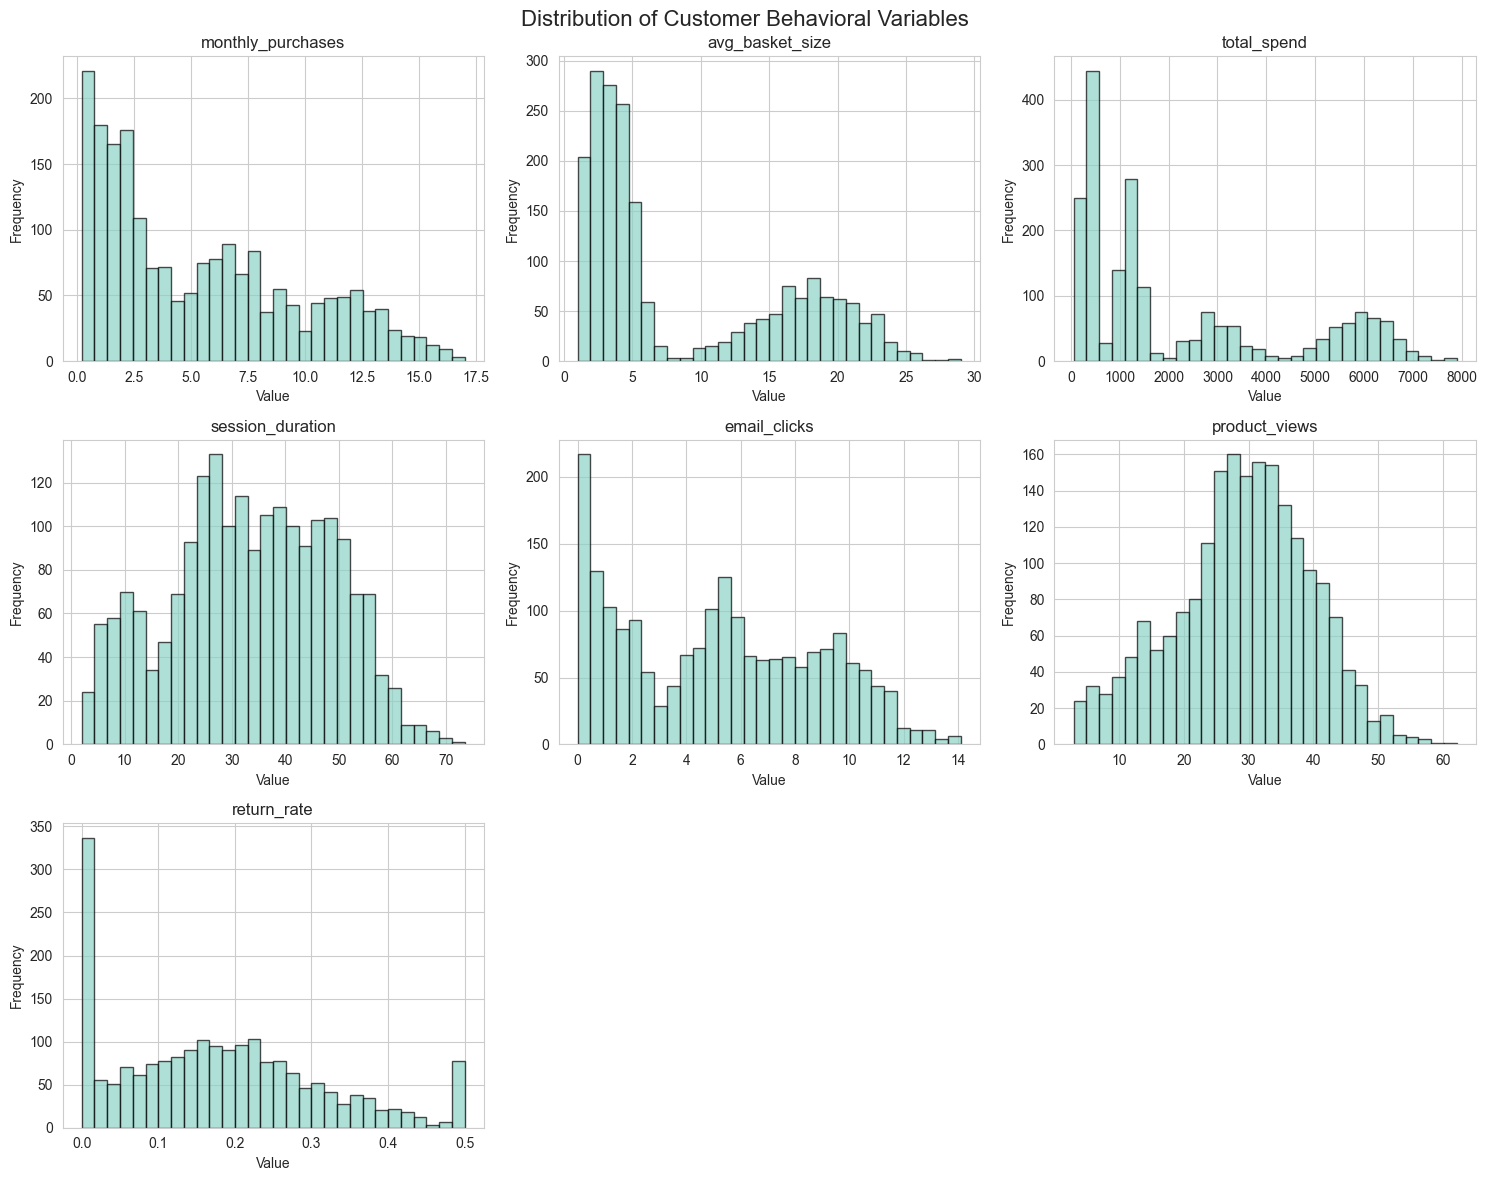

In [3]:
# Distribution plots for each variable
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle("Distribution of Customer Behavioral Variables", fontsize=16)

for idx, col in enumerate(df.columns):
    row = idx // 3
    col_idx = idx % 3
    axes[row, col_idx].hist(df[col], bins=30, edgecolor='black', alpha=0.7)
    axes[row, col_idx].set_title(col)
    axes[row, col_idx].set_xlabel("Value")
    axes[row, col_idx].set_ylabel("Frequency")

# Hide unused subplots
for idx in range(len(df.columns), 9):
    row = idx // 3
    col_idx = idx % 3
    axes[row, col_idx].axis('off')

plt.tight_layout()
plt.savefig("customer_distributions.png", dpi=300, bbox_inches='tight')
logger.info("Saved distribution plots to customer_distributions.png")
plt.show()

INFO: Saved correlation matrix to correlation_matrix.png


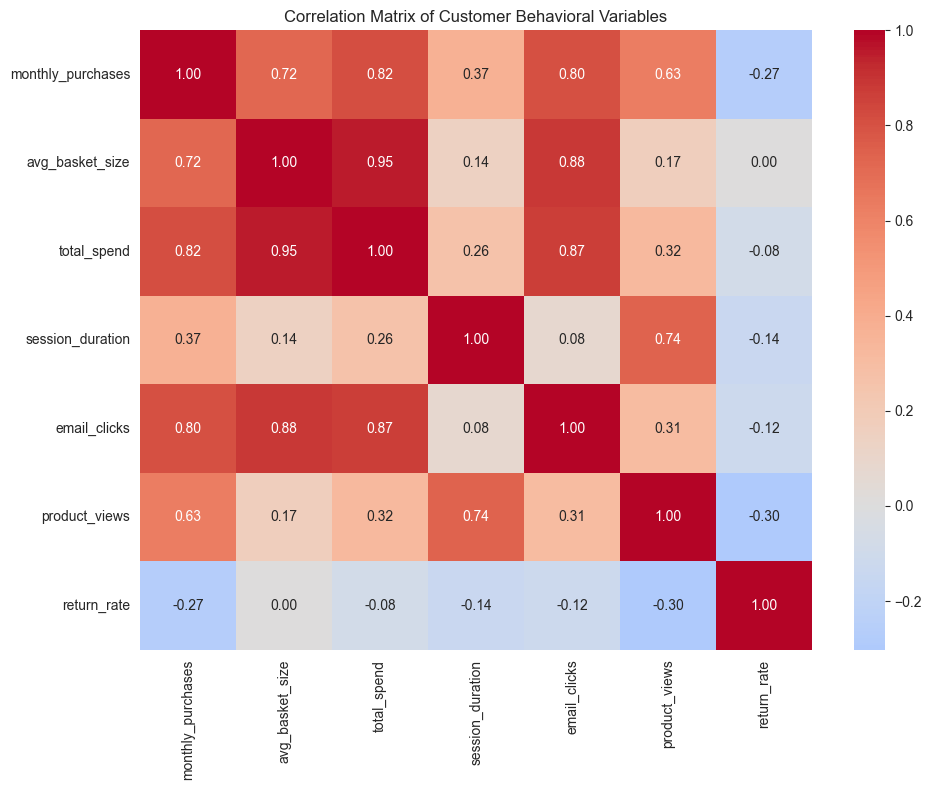


=== Strongest Correlations ===
avg_basket_size <-> total_spend: 0.950
avg_basket_size <-> email_clicks: 0.884
total_spend <-> email_clicks: 0.871
monthly_purchases <-> total_spend: 0.816
monthly_purchases <-> email_clicks: 0.804


In [4]:
# Correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Customer Behavioral Variables")
plt.tight_layout()
plt.savefig("correlation_matrix.png", dpi=300, bbox_inches='tight')
logger.info("Saved correlation matrix to correlation_matrix.png")
plt.show()

print("\n=== Strongest Correlations ===")
corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_pairs.append((
            correlation_matrix.columns[i],
            correlation_matrix.columns[j],
            correlation_matrix.iloc[i, j]
        ))

corr_pairs_sorted = sorted(corr_pairs, key=lambda x: abs(x[2]), reverse=True)
for var1, var2, corr in corr_pairs_sorted[:5]:
    print(f"{var1} <-> {var2}: {corr:.3f}")

## Data Standardization

**Task:** Standardize all variables to have mean = 0 and standard deviation = 1. This is critical in cluster analysis because distance-based algorithms are sensitive to variable scales. Without standardization, variables with larger ranges would dominate the clustering.

In [5]:
# Standardize features
scaler = StandardScaler()
X_standardized = scaler.fit_transform(df)

# Convert back to DataFrame for easier handling
df_standardized = pd.DataFrame(X_standardized, columns=df.columns)

logger.info("Data standardized: mean approx 0, std approx 1 for all variables")

print("\n=== Standardized Data Summary ===")
print(df_standardized.describe())

INFO: Data standardized: mean approx 0, std approx 1 for all variables



=== Standardized Data Summary ===
       monthly_purchases  avg_basket_size   total_spend  session_duration  \
count       2.000000e+03     2.000000e+03  2.000000e+03      2.000000e+03   
mean        2.309264e-17    -9.237056e-17  9.592327e-17      3.161915e-16   
std         1.000250e+00     1.000250e+00  1.000250e+00      1.000250e+00   
min        -1.198846e+00    -1.042450e+00 -9.880783e-01     -2.099970e+00   
25%        -8.734450e-01    -7.869722e-01 -8.289127e-01     -6.910288e-01   
50%        -2.691296e-01    -5.651100e-01 -4.533984e-01      1.010297e-02   
75%         6.838294e-01     1.028264e+00  5.361986e-01      8.113964e-01   
max         2.705962e+00     2.722485e+00  2.588786e+00      2.674404e+00   

       email_clicks  product_views   return_rate  
count  2.000000e+03   2.000000e+03  2.000000e+03  
mean   1.598721e-16  -1.980638e-16  2.451372e-16  
std    1.000250e+00   1.000250e+00  1.000250e+00  
min   -1.419276e+00  -2.461135e+00 -1.310345e+00  
25%   -9.518164e

## Hierarchical Clustering Analysis

**Task:** Apply hierarchical clustering using different linkage methods (single, complete, average, Ward's). Create dendrograms to visualize the clustering hierarchy and identify the optimal number of clusters by looking for large vertical gaps.

INFO: Computed single linkage
INFO: Computed complete linkage
INFO: Computed average linkage
INFO: Computed ward linkage
INFO: Saved dendrograms to dendrograms_comparison.png


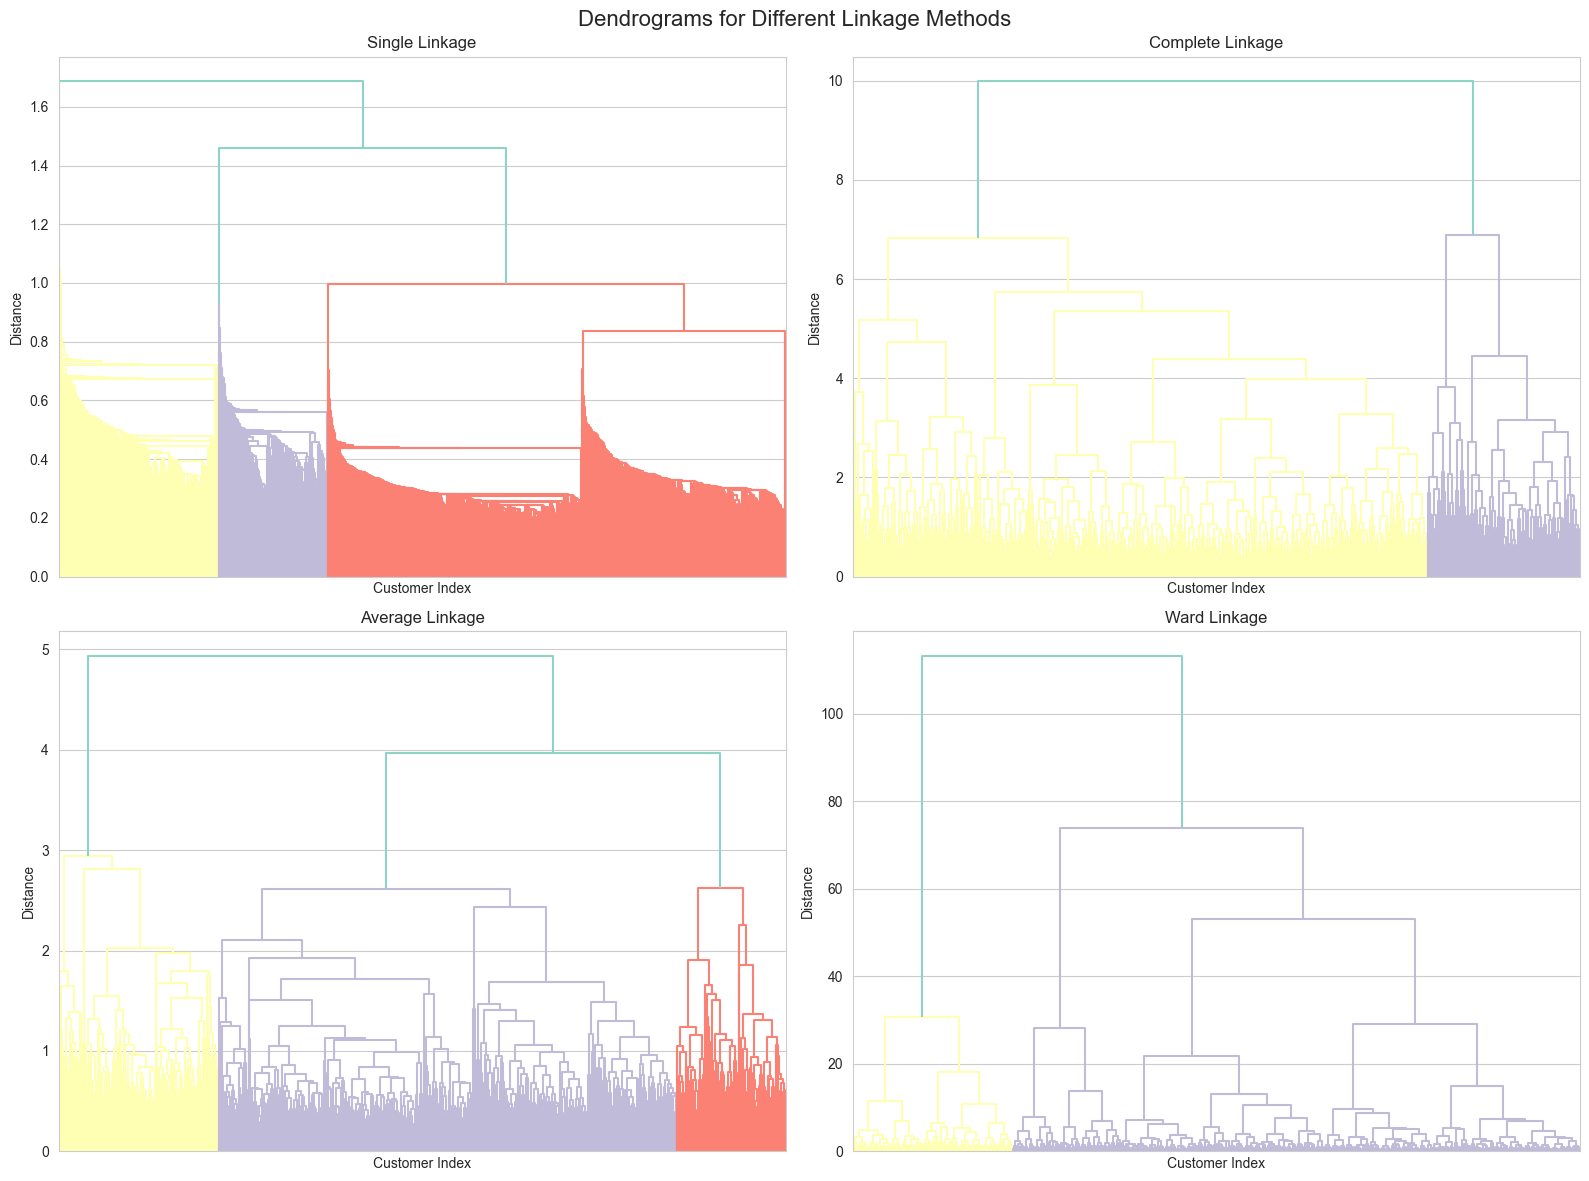

In [6]:
# Compute linkage matrices for different methods
linkage_methods = ['single', 'complete', 'average', 'ward']
linkage_matrices = {}

for method in linkage_methods:
    linkage_matrices[method] = linkage(X_standardized, method=method)
    logger.info(f"Computed {method} linkage")

# Create dendrograms for each method
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("Dendrograms for Different Linkage Methods", fontsize=16)

for idx, method in enumerate(linkage_methods):
    row = idx // 2
    col = idx % 2
    
    ax = axes[row, col]
    dendrogram(linkage_matrices[method], ax=ax, no_labels=True)
    ax.set_title(f"{method.capitalize()} Linkage")
    ax.set_xlabel("Customer Index")
    ax.set_ylabel("Distance")

plt.tight_layout()
plt.savefig("dendrograms_comparison.png", dpi=300, bbox_inches='tight')
logger.info("Saved dendrograms to dendrograms_comparison.png")
plt.show()

### Focused Dendrogram Analysis

**Task:** Create a more detailed dendrogram using Ward's method (most common for customer segmentation) and identify the optimal cutting point. Ward's method minimizes within-cluster variance, producing compact, spherical clusters.

INFO: Saved detailed Ward dendrogram


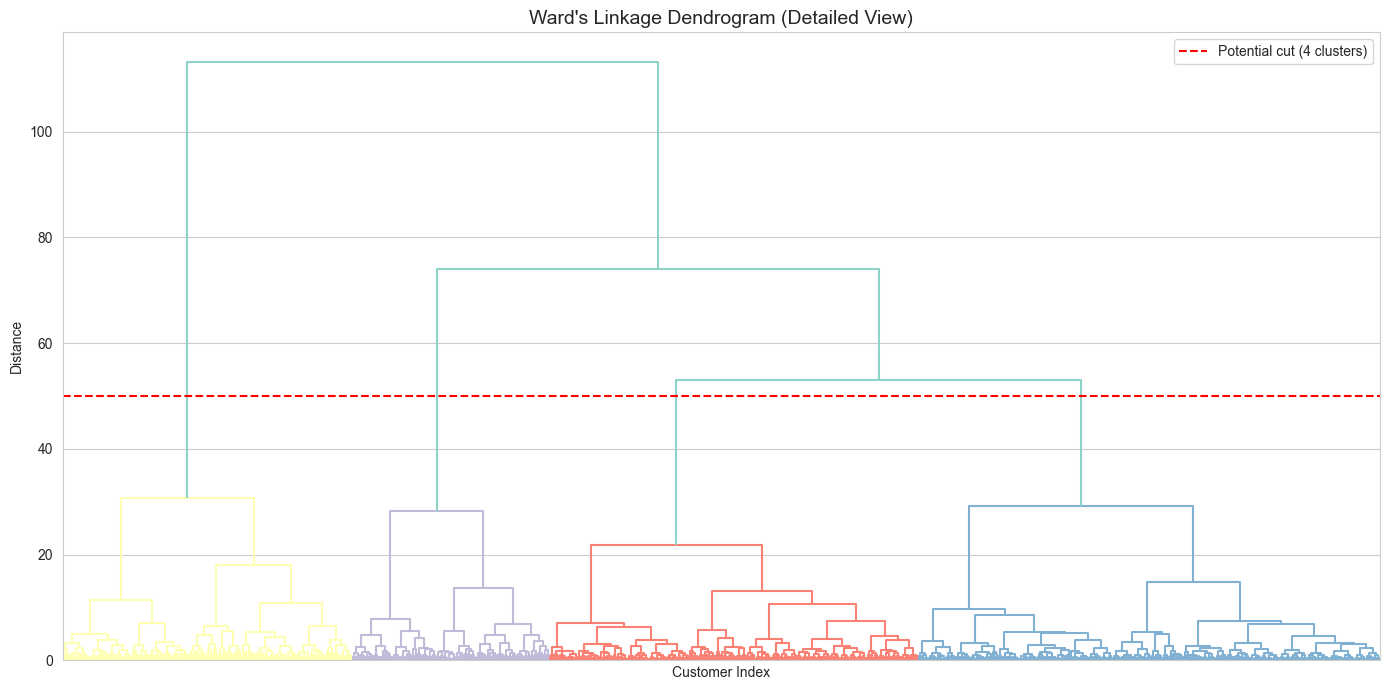


Interpretation: Look for large vertical gaps in the dendrogram.
A horizontal cut at a large gap suggests a natural number of clusters.
The red dashed line shows a potential cut point suggesting 4 clusters.


In [7]:
# Detailed Ward dendrogram
plt.figure(figsize=(14, 7))
dendrogram(linkage_matrices['ward'], no_labels=True, color_threshold=50)
plt.title("Ward's Linkage Dendrogram (Detailed View)", fontsize=14)
plt.xlabel("Customer Index")
plt.ylabel("Distance")
plt.axhline(y=50, color='r', linestyle='--', label='Potential cut (4 clusters)')
plt.legend()
plt.tight_layout()
plt.savefig("ward_dendrogram_detailed.png", dpi=300, bbox_inches='tight')
logger.info("Saved detailed Ward dendrogram")
plt.show()

print("\nInterpretation: Look for large vertical gaps in the dendrogram.")
print("A horizontal cut at a large gap suggests a natural number of clusters.")
print("The red dashed line shows a potential cut point suggesting 4 clusters.")

### Extract Hierarchical Clusters

**Task:** Cut the dendrogram to extract 4 clusters using Ward's method. Display the cluster sizes and calculate the silhouette score to measure cluster quality.

In [8]:
# Extract 4 clusters from Ward's linkage
n_clusters_hier = 4
hierarchical_labels = fcluster(linkage_matrices['ward'], n_clusters_hier, criterion='maxclust')

# Convert to 0-indexed for consistency
hierarchical_labels = hierarchical_labels - 1

logger.info(f"Extracted {n_clusters_hier} clusters using Ward's method")

print("\n=== Hierarchical Clustering Results (Ward's Method) ===")
print(f"Number of clusters: {n_clusters_hier}")
print("\nCluster sizes:")
unique, counts = np.unique(hierarchical_labels, return_counts=True)
for cluster_id, count in zip(unique, counts):
    percentage = (count / len(hierarchical_labels)) * 100
    print(f"  Cluster {cluster_id}: {count} customers ({percentage:.1f}%)")

# Calculate silhouette score
silhouette_hier = silhouette_score(X_standardized, hierarchical_labels)
print(f"\nSilhouette Score: {silhouette_hier:.3f}")
print("(Range: -1 to +1, higher is better, >0.5 indicates good clustering)")

INFO: Extracted 4 clusters using Ward's method



=== Hierarchical Clustering Results (Ward's Method) ===
Number of clusters: 4

Cluster sizes:
  Cluster 0: 440 customers (22.0%)
  Cluster 1: 300 customers (15.0%)
  Cluster 2: 560 customers (28.0%)
  Cluster 3: 700 customers (35.0%)

Silhouette Score: 0.458
(Range: -1 to +1, higher is better, >0.5 indicates good clustering)


## K-Means Clustering Analysis

**Task:** Apply the elbow method to determine the optimal number of clusters for k-means. Plot the within-cluster sum of squares (inertia) for k = 2 to 10 and identify the "elbow" point where adding more clusters yields diminishing returns.

INFO: K-means with k=2: inertia=7595.20, silhouette=0.486
INFO: K-means with k=3: inertia=4845.51, silhouette=0.499
INFO: K-means with k=4: inertia=3431.45, silhouette=0.458
INFO: K-means with k=5: inertia=2926.54, silhouette=0.431
INFO: K-means with k=6: inertia=2482.88, silhouette=0.397
INFO: K-means with k=7: inertia=2056.48, silhouette=0.400
INFO: K-means with k=8: inertia=1780.92, silhouette=0.379
INFO: K-means with k=9: inertia=1655.67, silhouette=0.356
INFO: K-means with k=10: inertia=1534.81, silhouette=0.329
INFO: Saved elbow and silhouette analysis plots


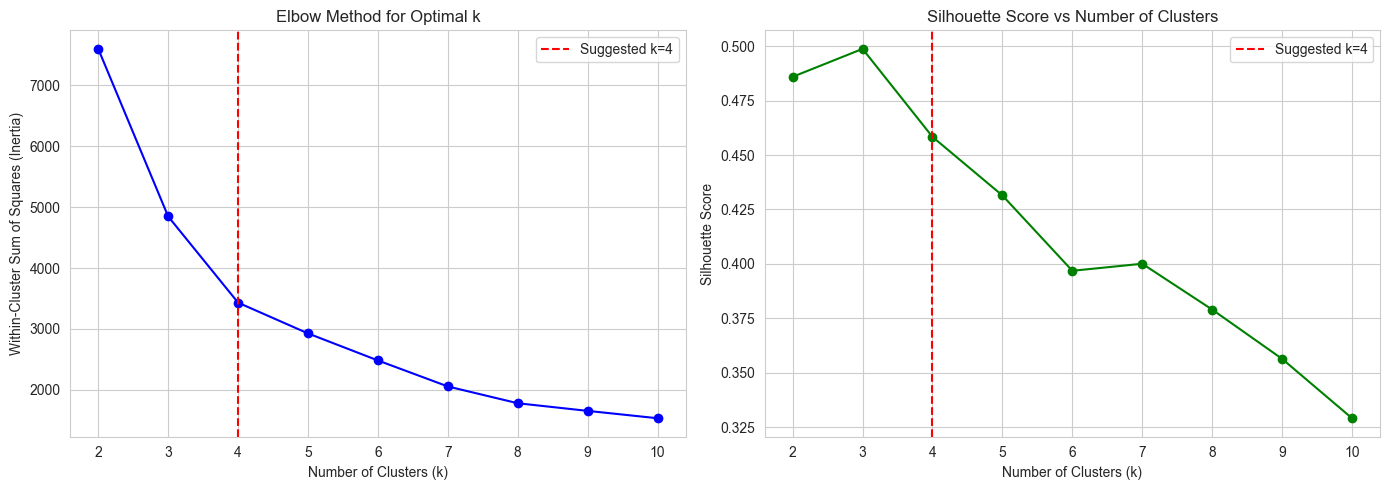


Interpretation:
- Elbow plot: Look for the 'elbow' where the rate of decrease slows
- Silhouette plot: Higher values indicate better-defined clusters
- Maximum silhouette score at k=3


In [9]:
# Elbow method to determine optimal k
inertias = []
silhouette_scores = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_standardized)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_standardized, kmeans.labels_))
    logger.info(f"K-means with k={k}: inertia={kmeans.inertia_:.2f}, silhouette={silhouette_scores[-1]:.3f}")

# Plot elbow curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(K_range, inertias, 'bo-')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Within-Cluster Sum of Squares (Inertia)')
ax1.set_title('Elbow Method for Optimal k')
ax1.grid(True)
ax1.axvline(x=4, color='r', linestyle='--', label='Suggested k=4')
ax1.legend()

ax2.plot(K_range, silhouette_scores, 'go-')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score vs Number of Clusters')
ax2.grid(True)
ax2.axvline(x=4, color='r', linestyle='--', label='Suggested k=4')
ax2.legend()

plt.tight_layout()
plt.savefig("elbow_silhouette_analysis.png", dpi=300, bbox_inches='tight')
logger.info("Saved elbow and silhouette analysis plots")
plt.show()

print("\nInterpretation:")
print("- Elbow plot: Look for the 'elbow' where the rate of decrease slows")
print("- Silhouette plot: Higher values indicate better-defined clusters")
print(f"- Maximum silhouette score at k={K_range[np.argmax(silhouette_scores)]}")

### Apply K-Means with Optimal k

**Task:** Run k-means clustering with k=4 (suggested by both hierarchical and elbow analyses). Display cluster sizes and compute the silhouette score to compare with hierarchical clustering.

In [10]:
# Apply k-means with optimal k
optimal_k = 4
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans_final.fit_predict(X_standardized)

logger.info(f"Applied k-means with k={optimal_k}")

print("\n=== K-Means Clustering Results ===")
print(f"Number of clusters: {optimal_k}")
print("\nCluster sizes:")
unique, counts = np.unique(kmeans_labels, return_counts=True)
for cluster_id, count in zip(unique, counts):
    percentage = (count / len(kmeans_labels)) * 100
    print(f"  Cluster {cluster_id}: {count} customers ({percentage:.1f}%)")

# Calculate silhouette score
silhouette_kmeans = silhouette_score(X_standardized, kmeans_labels)
print(f"\nSilhouette Score: {silhouette_kmeans:.3f}")

print("\n=== Comparison with Hierarchical Clustering ===")
print(f"Hierarchical (Ward) silhouette: {silhouette_hier:.3f}")
print(f"K-means silhouette: {silhouette_kmeans:.3f}")

INFO: Applied k-means with k=4



=== K-Means Clustering Results ===
Number of clusters: 4

Cluster sizes:
  Cluster 0: 307 customers (15.3%)
  Cluster 1: 707 customers (35.4%)
  Cluster 2: 432 customers (21.6%)
  Cluster 3: 554 customers (27.7%)

Silhouette Score: 0.458

=== Comparison with Hierarchical Clustering ===
Hierarchical (Ward) silhouette: 0.458
K-means silhouette: 0.458


## Cluster Interpretation and Profiling

**Task:** For each cluster discovered by k-means, calculate the mean values of all behavioral variables (in original units, not standardized). Create a heatmap showing cluster profiles to identify distinguishing characteristics of each segment.


=== K-Means Cluster Profiles (Mean Values) ===
                monthly_purchases  avg_basket_size  total_spend  \
Cluster_KMeans                                                    
0                            3.10            15.06      3055.75   
1                            1.28             2.54       360.03   
2                           12.00            19.91      5962.36   
3                            6.63             4.48      1220.37   

                session_duration  email_clicks  product_views  return_rate  
Cluster_KMeans                                                              
0                          10.17          7.84          12.17         0.28  
1                          39.79          1.12          26.76         0.20  
2                          49.61          9.92          39.83         0.13  
3                          25.66          5.12          32.54         0.12  


INFO: Saved cluster profiles heatmap


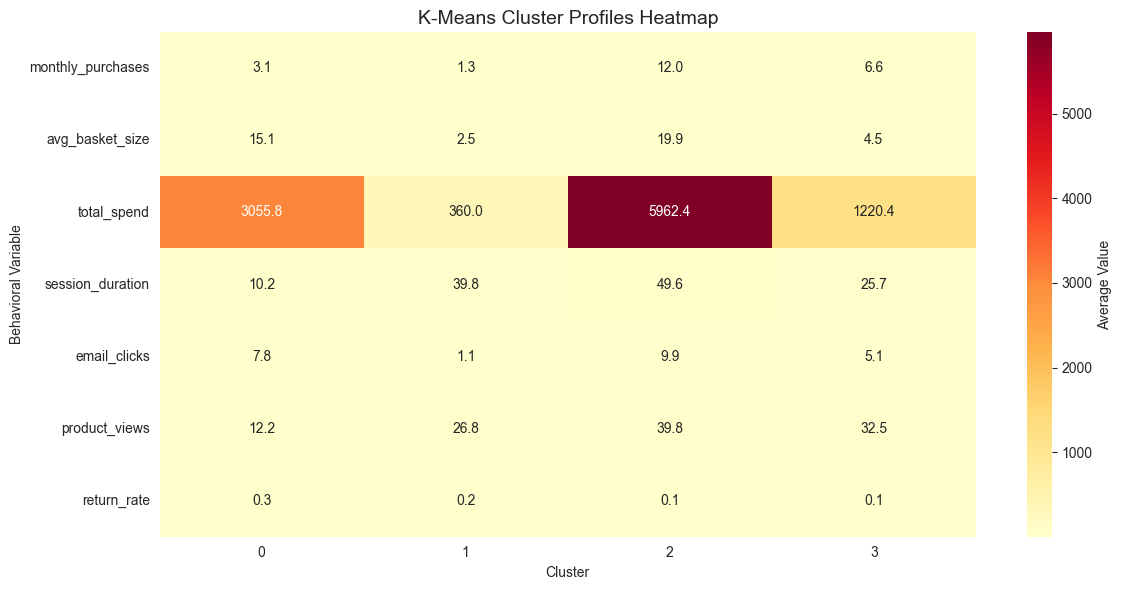

In [11]:
# Add cluster labels to original data
df_with_clusters = df.copy()
df_with_clusters['Cluster_KMeans'] = kmeans_labels
df_with_clusters['Cluster_Hierarchical'] = hierarchical_labels

# Calculate cluster means (in original units)
cluster_profiles = df_with_clusters.groupby('Cluster_KMeans')[df.columns].mean()

print("\n=== K-Means Cluster Profiles (Mean Values) ===")
print(cluster_profiles.round(2))

# Create heatmap of cluster profiles
plt.figure(figsize=(12, 6))
sns.heatmap(cluster_profiles.T, annot=True, fmt='.1f', cmap='YlOrRd', cbar_kws={'label': 'Average Value'})
plt.title('K-Means Cluster Profiles Heatmap', fontsize=14)
plt.xlabel('Cluster')
plt.ylabel('Behavioral Variable')
plt.tight_layout()
plt.savefig("cluster_profiles_heatmap.png", dpi=300, bbox_inches='tight')
logger.info("Saved cluster profiles heatmap")
plt.show()

### Detailed Cluster Characterization

**Task:** For each cluster, identify the most distinctive characteristics by comparing each cluster's mean to the overall dataset mean. This helps assign business-meaningful names to clusters (e.g., 'High-Value Customers', 'Bargain Hunters').

In [12]:
# Compare each cluster to overall means
overall_means = df.mean()

print("\n=== Cluster Characterization (Comparison to Overall Means) ===")
for cluster_id in range(optimal_k):
    print(f"\nCluster {cluster_id} (n={counts[cluster_id]}, {(counts[cluster_id]/len(df)*100):.1f}%):")
    cluster_mean = cluster_profiles.loc[cluster_id]
    
    # Find features significantly above or below average
    differences = ((cluster_mean - overall_means) / overall_means * 100)
    
    # Show top distinguishing features
    high_features = differences.nlargest(3)
    low_features = differences.nsmallest(3)
    
    print("  Distinctive High Features:")
    for feat, diff in high_features.items():
        if diff > 10:
            print(f"    - {feat}: {diff:+.1f}% vs average")
    
    print("  Distinctive Low Features:")
    for feat, diff in low_features.items():
        if diff < -10:
            print(f"    - {feat}: {diff:+.1f}% vs average")


=== Cluster Characterization (Comparison to Overall Means) ===

Cluster 0 (n=307, 15.3%):
  Distinctive High Features:
    - avg_basket_size: +72.0% vs average
    - return_rate: +56.2% vs average
    - email_clicks: +51.9% vs average
  Distinctive Low Features:
    - session_duration: -69.6% vs average
    - product_views: -58.0% vs average
    - monthly_purchases: -42.1% vs average

Cluster 1 (n=707, 35.4%):
  Distinctive High Features:
    - session_duration: +19.0% vs average
    - return_rate: +15.2% vs average
  Distinctive Low Features:
    - total_spend: -83.8% vs average
    - email_clicks: -78.3% vs average
    - monthly_purchases: -76.2% vs average

Cluster 2 (n=432, 21.6%):
  Distinctive High Features:
    - total_spend: +168.3% vs average
    - avg_basket_size: +127.5% vs average
    - monthly_purchases: +124.1% vs average
  Distinctive Low Features:
    - return_rate: -24.1% vs average

Cluster 3 (n=554, 27.7%):
  Distinctive High Features:
    - monthly_purchases: +23.8

## Cluster Validation with Silhouette Analysis

**Task:** Create a silhouette plot showing the silhouette coefficient for each customer, grouped by cluster. This visualizes cluster cohesion (how well each point fits within its cluster) and separation (how distinct clusters are from each other).

INFO: Saved silhouette plot


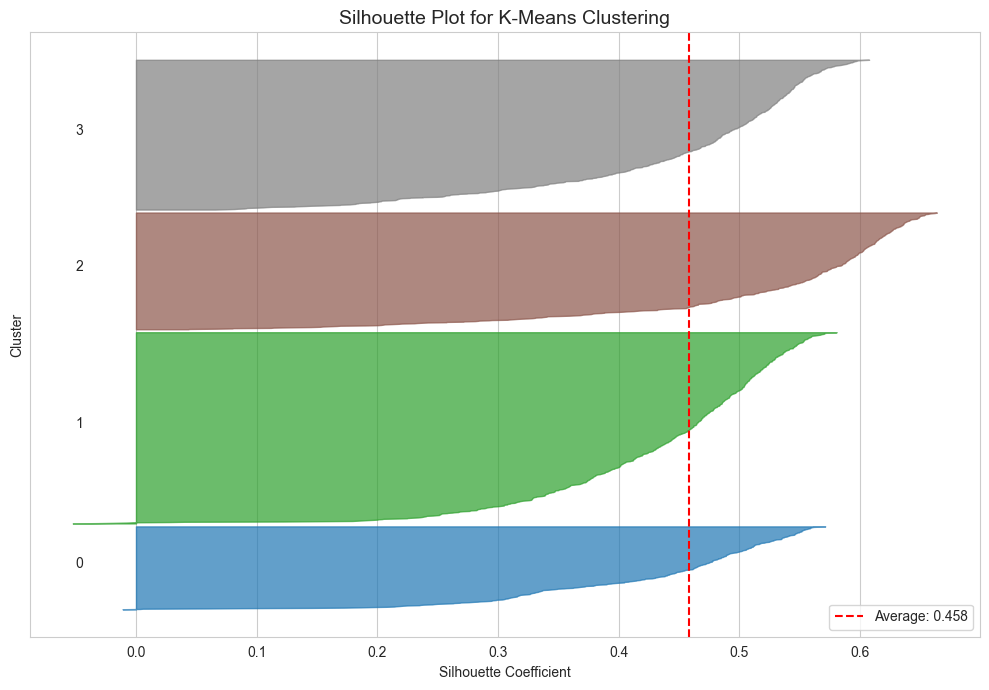


Interpretation:
- Width of silhouette plot = cluster size
- Silhouette coefficient close to +1: well-matched to own cluster
- Silhouette coefficient close to 0: on border between clusters
- Silhouette coefficient close to -1: possibly assigned to wrong cluster
- Red dashed line shows average silhouette score across all customers


In [13]:
# Calculate silhouette values for each sample
silhouette_vals = silhouette_samples(X_standardized, kmeans_labels)

# Create silhouette plot
fig, ax = plt.subplots(figsize=(10, 7))

y_lower = 10
for i in range(optimal_k):
    # Get silhouette values for cluster i
    cluster_silhouette_vals = silhouette_vals[kmeans_labels == i]
    cluster_silhouette_vals.sort()
    
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = plt.cm.tab10(i / optimal_k)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals,
                     facecolor=color, edgecolor=color, alpha=0.7)
    
    # Label the silhouette plots with cluster numbers
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    y_lower = y_upper + 10

ax.set_title('Silhouette Plot for K-Means Clustering', fontsize=14)
ax.set_xlabel('Silhouette Coefficient')
ax.set_ylabel('Cluster')
ax.axvline(x=silhouette_kmeans, color="red", linestyle="--", label=f'Average: {silhouette_kmeans:.3f}')
ax.set_yticks([])
ax.legend()
plt.tight_layout()
plt.savefig("silhouette_plot.png", dpi=300, bbox_inches='tight')
logger.info("Saved silhouette plot")
plt.show()

print("\nInterpretation:")
print("- Width of silhouette plot = cluster size")
print("- Silhouette coefficient close to +1: well-matched to own cluster")
print("- Silhouette coefficient close to 0: on border between clusters")
print("- Silhouette coefficient close to -1: possibly assigned to wrong cluster")
print("- Red dashed line shows average silhouette score across all customers")

## Visualization in 2D Space (PCA Projection)

**Task:** Since we cannot visualize 7-dimensional data directly, use Principal Component Analysis (PCA) to project the data onto the first two principal components. Plot customers colored by their cluster assignments to visualize cluster separation.

INFO: PCA variance explained: PC1=0.555, PC2=0.235
INFO: Total variance explained by 2 components: 0.790
INFO: Saved PCA cluster visualization


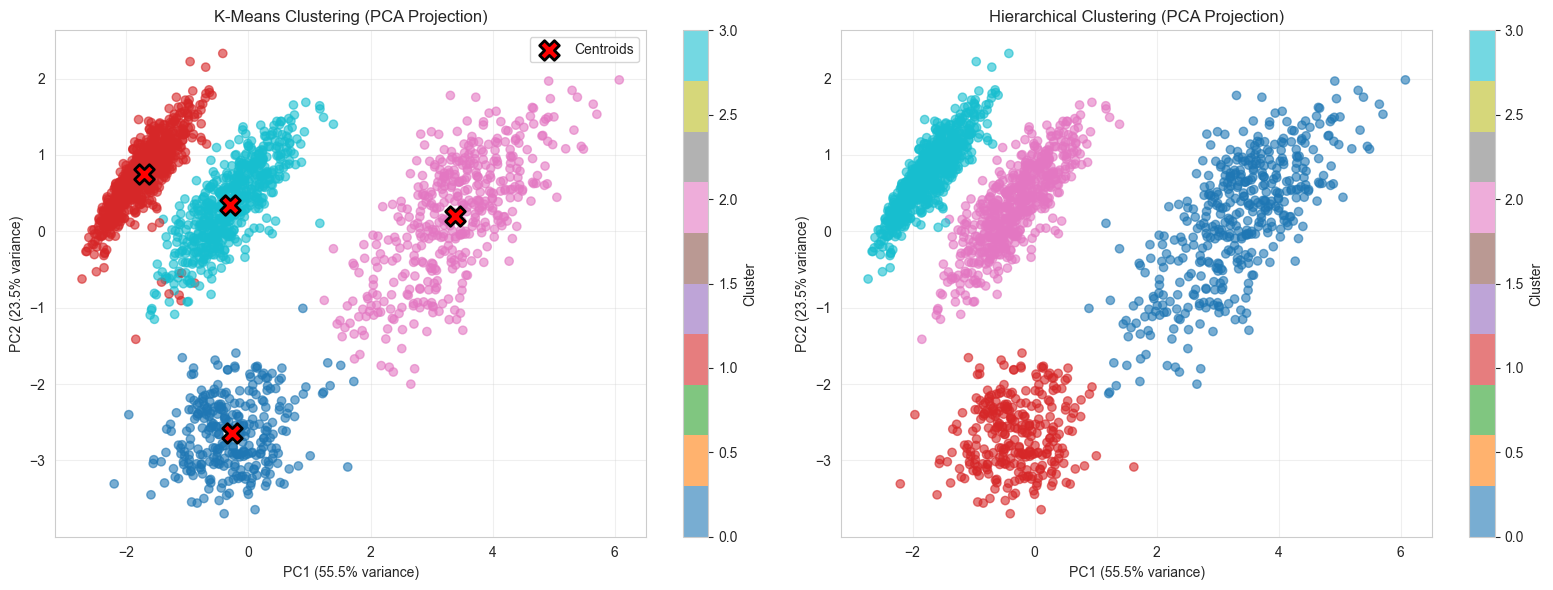


Note: This 2D projection captures 79.0% of total variance.
The actual clusters exist in 7-dimensional space and may be more separated than shown here.


In [14]:
from sklearn.decomposition import PCA

# Apply PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_standardized)

logger.info(f"PCA variance explained: PC1={pca.explained_variance_ratio_[0]:.3f}, PC2={pca.explained_variance_ratio_[1]:.3f}")
logger.info(f"Total variance explained by 2 components: {pca.explained_variance_ratio_.sum():.3f}")

# Create scatter plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# K-means clusters
scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='tab10', alpha=0.6)
ax1.scatter(pca.transform(kmeans_final.cluster_centers_)[:, 0], 
           pca.transform(kmeans_final.cluster_centers_)[:, 1],
           marker='X', s=200, c='red', edgecolors='black', linewidths=2, label='Centroids')
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax1.set_title('K-Means Clustering (PCA Projection)')
ax1.legend()
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=ax1, label='Cluster')

# Hierarchical clusters
scatter2 = ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=hierarchical_labels, cmap='tab10', alpha=0.6)
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax2.set_title('Hierarchical Clustering (PCA Projection)')
ax2.grid(True, alpha=0.3)
plt.colorbar(scatter2, ax=ax2, label='Cluster')

plt.tight_layout()
plt.savefig("cluster_visualization_pca.png", dpi=300, bbox_inches='tight')
logger.info("Saved PCA cluster visualization")
plt.show()

print(f"\nNote: This 2D projection captures {pca.explained_variance_ratio_.sum():.1%} of total variance.")
print("The actual clusters exist in 7-dimensional space and may be more separated than shown here.")

## Business Recommendations

**Task:** Based on the cluster profiles, develop targeted marketing strategies for each customer segment. Consider the distinctive characteristics of each cluster when formulating recommendations.

In [15]:
print("\n" + "="*70)
print("BUSINESS RECOMMENDATIONS BY CLUSTER")
print("="*70)

print("\nBased on cluster analysis, tailor marketing strategies as follows:\n")

# Generic recommendations - instructor should customize based on actual cluster profiles
recommendations = {
    "High-Spending, Frequent Shoppers": [
        "Launch VIP loyalty program with exclusive perks",
        "Offer early access to new products and sales",
        "Provide free expedited shipping",
        "Personalized product recommendations based on purchase history"
    ],
    "Price-Sensitive, Small-Basket Buyers": [
        "Send targeted discount codes and bundle offers",
        "Promote free shipping thresholds to increase basket size",
        "Highlight clearance and sale items in email campaigns",
        "Create value packs and multi-buy promotions"
    ],
    "Browsers with Low Conversion": [
        "Implement abandoned cart recovery campaigns",
        "Use retargeting ads to re-engage visitors",
        "Offer limited-time discounts to incentivize first purchase",
        "Improve product information and customer reviews to build trust"
    ],
    "Sporadic High-Value Buyers": [
        "Send promotional emails highlighting new arrivals and special offers",
        "Create urgency with flash sales and limited-time deals",
        "Implement win-back campaigns during inactive periods",
        "Offer flexible return policies to reduce purchase anxiety"
    ]
}

for segment_name, strategies in recommendations.items():
    print(f"\n{segment_name}:")
    for strategy in strategies:
        print(f"  - {strategy}")

print("\n" + "="*70)
print("\nNext Steps:")
print("1. Validate cluster assignments with domain experts")
print("2. Implement targeted campaigns for each segment")
print("3. Monitor segment-specific KPIs (conversion, AOV, retention)")
print("4. Re-run clustering periodically to detect shifts in customer behavior")
print("5. Consider additional features (geographic, demographic) for refinement")
print("="*70)


BUSINESS RECOMMENDATIONS BY CLUSTER

Based on cluster analysis, tailor marketing strategies as follows:


High-Spending, Frequent Shoppers:
  - Launch VIP loyalty program with exclusive perks
  - Offer early access to new products and sales
  - Provide free expedited shipping
  - Personalized product recommendations based on purchase history

Price-Sensitive, Small-Basket Buyers:
  - Send targeted discount codes and bundle offers
  - Promote free shipping thresholds to increase basket size
  - Highlight clearance and sale items in email campaigns
  - Create value packs and multi-buy promotions

Browsers with Low Conversion:
  - Implement abandoned cart recovery campaigns
  - Use retargeting ads to re-engage visitors
  - Offer limited-time discounts to incentivize first purchase
  - Improve product information and customer reviews to build trust

Sporadic High-Value Buyers:
  - Send promotional emails highlighting new arrivals and special offers
  - Create urgency with flash sales and 

## Comparison with True Labels (Validation Only)

**Task:** Load the validation dataset (which contains true cluster labels from data generation) to assess how well our unsupervised clustering recovered the underlying structure. Calculate the Adjusted Rand Index to measure agreement between discovered and true clusters.

**Important Note:** In real-world unsupervised learning, true labels do not exist. This validation step is only possible because we generated synthetic data with known structure. In practice, cluster validation relies on domain expertise and business metrics.


=== Validation Against True Clusters (Educational Purpose Only) ===
K-means Adjusted Rand Index: 0.981
Hierarchical Adjusted Rand Index: 1.000

(ARI ranges from -1 to 1, where 1 = perfect match, 0 = random)

=== True Cluster Distribution ===
true_cluster
BargainHunters    560
ImpulseBuyers     300
PowerShoppers     440
WindowShoppers    700
Name: count, dtype: int64


INFO: Saved validation confusion matrix


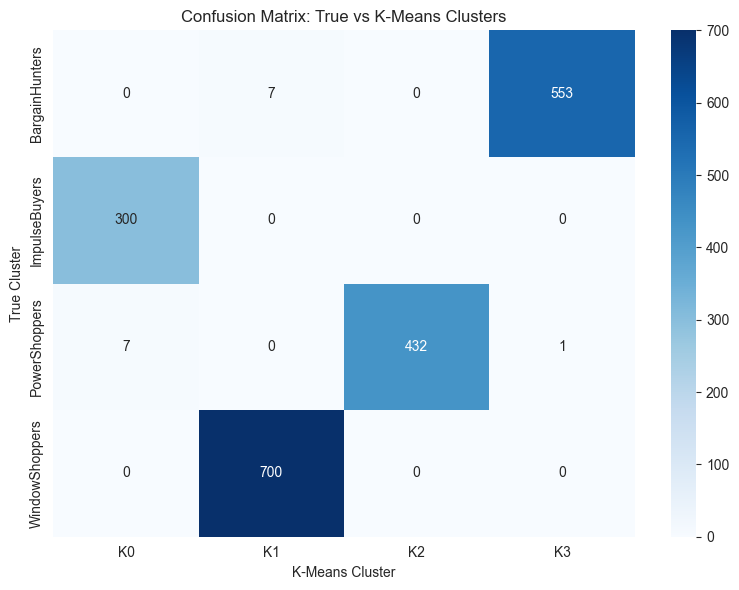


Note: This validation is only possible because we generated synthetic data.
In real applications, there are no 'true' labels to compare against.


In [16]:
from sklearn.metrics import adjusted_rand_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Load validation file with true labels
validation_file = script_dir / "customer_data_with_labels.csv"

if validation_file.exists():
    df_validation = pd.read_csv(validation_file)
    true_labels_str = df_validation['true_cluster']
    
    # Encode string labels to numeric for confusion matrix
    label_encoder = LabelEncoder()
    true_labels_encoded = label_encoder.fit_transform(true_labels_str)
    
    # Calculate Adjusted Rand Index (works with both string and numeric labels)
    ari_kmeans = adjusted_rand_score(true_labels_str, kmeans_labels)
    ari_hierarchical = adjusted_rand_score(true_labels_str, hierarchical_labels)
    
    print("\n=== Validation Against True Clusters (Educational Purpose Only) ===")
    print(f"K-means Adjusted Rand Index: {ari_kmeans:.3f}")
    print(f"Hierarchical Adjusted Rand Index: {ari_hierarchical:.3f}")
    print("\n(ARI ranges from -1 to 1, where 1 = perfect match, 0 = random)")
    
    # Show true cluster distribution
    print("\n=== True Cluster Distribution ===")
    print(true_labels_str.value_counts().sort_index())
    
    # Create confusion matrix using encoded labels
    cm = confusion_matrix(true_labels_encoded, kmeans_labels)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=[f'K{i}' for i in range(optimal_k)],
                yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix: True vs K-Means Clusters')
    plt.xlabel('K-Means Cluster')
    plt.ylabel('True Cluster')
    plt.tight_layout()
    plt.savefig("validation_confusion_matrix.png", dpi=300, bbox_inches='tight')
    logger.info("Saved validation confusion matrix")
    plt.show()
    
    print("\nNote: This validation is only possible because we generated synthetic data.")
    print("In real applications, there are no 'true' labels to compare against.")
else:
    print("\nValidation file not found. Skipping true label comparison.")
    print("Run fetch_customer_data.py to generate the validation dataset.")

## Summary and Key Takeaways

**Task:** Summarize the entire cluster analysis workflow, key findings, and methodological insights.

In [17]:
print("\n" + "="*70)
print("CLUSTER ANALYSIS SUMMARY")
print("="*70)

print("\n1. METHODOLOGY")
print("   - Analyzed 2,000 customers across 7 behavioral variables")
print("   - Standardized data to ensure equal feature weighting")
print("   - Applied both hierarchical (Ward's linkage) and k-means clustering")
print("   - Used elbow method, silhouette analysis, and dendrogram inspection")

print("\n2. OPTIMAL NUMBER OF CLUSTERS")
print(f"   - Both methods suggested k = {optimal_k} clusters")
print(f"   - K-means silhouette score: {silhouette_kmeans:.3f}")
print(f"   - Hierarchical silhouette score: {silhouette_hier:.3f}")

print("\n3. CLUSTER SIZES (K-Means)")
for cluster_id, count in zip(unique, counts):
    percentage = (count / len(kmeans_labels)) * 100
    print(f"   - Cluster {cluster_id}: {count} customers ({percentage:.1f}%)")

print("\n4. KEY INSIGHTS")
print("   - Distinct customer segments exist with different behavioral patterns")
print("   - Segments vary in spending levels, purchase frequency, and engagement")
print("   - Each segment requires tailored marketing strategies")

print("\n5. METHODOLOGICAL LEARNINGS")
print("   - Hierarchical clustering: Provides hierarchy view, no need to predefine k")
print("   - K-means: More scalable, faster, but requires specifying k")
print("   - Both methods converged on similar cluster structure")
print("   - Standardization is critical when variables have different scales")

print("\n6. BUSINESS VALUE")
print("   - Enables targeted marketing campaigns by segment")
print("   - Optimizes resource allocation to high-value customers")
print("   - Identifies opportunities for customer retention and growth")
print("   - Provides data-driven customer understanding")

print("\n" + "="*70)
logger.info("Cluster analysis completed successfully")

INFO: Cluster analysis completed successfully



CLUSTER ANALYSIS SUMMARY

1. METHODOLOGY
   - Analyzed 2,000 customers across 7 behavioral variables
   - Standardized data to ensure equal feature weighting
   - Applied both hierarchical (Ward's linkage) and k-means clustering
   - Used elbow method, silhouette analysis, and dendrogram inspection

2. OPTIMAL NUMBER OF CLUSTERS
   - Both methods suggested k = 4 clusters
   - K-means silhouette score: 0.458
   - Hierarchical silhouette score: 0.458

3. CLUSTER SIZES (K-Means)
   - Cluster 0: 307 customers (15.3%)
   - Cluster 1: 707 customers (35.4%)
   - Cluster 2: 432 customers (21.6%)
   - Cluster 3: 554 customers (27.7%)

4. KEY INSIGHTS
   - Distinct customer segments exist with different behavioral patterns
   - Segments vary in spending levels, purchase frequency, and engagement
   - Each segment requires tailored marketing strategies

5. METHODOLOGICAL LEARNINGS
   - Hierarchical clustering: Provides hierarchy view, no need to predefine k
   - K-means: More scalable, faster, b